In [1]:
# merge new statistics as a sum-up file
import pandas as pd 
import os,glob
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import hydroeval as he
from matplotlib.colors import LogNorm
from pylab import *
import pandas as pd 
from sklearn.datasets import make_regression

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
#from xgboost import XGBRegressor
import sklearn.neural_network as nn

from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
def merge_xls(filelist):
    df = pd.DataFrame()
    for file in filelist:
        df = df.append(pd.read_excel(file),ignore_index = True)
    return df

def link_newstat(oldfile,newfile):
    df_1 =  pd.read_excel(oldfile)
    df_1['I_slope'] = df_1['I_slope'].round(3)
    df_1 = df_1.drop_duplicates(keep = 'last')
    df_1 = df_1.reset_index(drop = True)
    
    df_2 =  pd.read_excel(newfile)
    df_2 = df_2.rename(columns={'mean':'mean_bio'})
    df_2.loc[:,'mean_copy'] = df_2['mean_bio']

    df_1['mean_bio'] = df_1['mean_bio'].round(1)
    df_1['mu'] = df_1['mu'].round(3)
    df_1['alpha'] = df_1['alpha'].round(3)
    df_1['I_slope'] = df_1['I_slope'].round(3)

    df_2['mean_bio'] = df_2['mean_bio'].round(1)
    df_2['mu'] = df_2['mu'].round(3)
    df_2['alpha'] = df_2['alpha'].round(3)
    df_2['I_slope'] = df_2['I_slope'].round(3)

    df_3 = pd.merge(df_1,df_2, how='inner', on=['mu','alpha','I_slope','mean_bio'])
    df_3 = df_3.drop(['entropy','mean_copy'],axis=1)
    return df_3

In [ ]:
# import numpy as np 
# Ks = np.arange(0.025,0.225,0.025) #[0.025:0.025:0.2]
# df = pd.DataFrame()

# for K in Ks:
#     testfile = glob.glob(r'./Merged/*K_%.3f*.xlsx' %(K))
#     df_k = pd.read_excel(testfile[0],
#                          engine='openpyxl')
#     df_k['K'] = K
#     df = df.append(df_k,ignore_index = True)
# df
# df_1 = df.loc[(df['alpha'] > 0.95)].reset_index(drop = True)
# df_1['alpha'].unique()
# df_1.to_csv('Merged_all_statistics_a_[1:1.8]_Kb[0.025:0.025:0.20].csv')
# df_1['Shuffle_index'].unique()


## import data


In [ ]:
allfile = 'Merged_all_statistics_a_[1:1.8]_Kb[0.025:0.025:0.20].csv'
df_1 = pd.read_csv(allfile)
df_1 = df_1.iloc[: , 1:]

df_2=df_1[df_1.columns[[0,2,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,22]]]
df_3 = df_2.loc[(df_2['Shuffle_index'] > 0)].reset_index(drop = True)
df_all= df_3.drop(['entropy','Shuffle_index'],axis=1)
#df_all = df_all.rename(columns={'beta':'I_slope'})
new_column_names = {'mean_bio':'AGBmean',
                    'median_bio':'AGBmed',
                    'range_bio':'AGBrange',
                    'var_bio':'AGBvar',
                    'std_bio':'AGBstd',
                    'cv_bio':'AGBcv',
                    'skew_bio':'AGBskew',
                    'kurt_bio':'AGBkurt',
                    'prc25_bio':'AGBp25',
                    'prc75_bio':'AGBp75',
                    'Trimean':'AGBtrim'}
df_all = df_all.rename(columns=new_column_names)
df_all


In [ ]:
import seaborn as sns
correlation_matrix = df_all[['AGBmean','AGBrange','AGBmed', 'AGBcv','AGBstd']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation')
plt.show()

In [ ]:
#['mu', 'beta', 'alpha', 'mean_bio', 'median_bio', 'range_bio', 'var_bio',
#        'std_bio', 'cv_bio', 'skew_bio', 'kurt_bio', 'prc25_bio', 'prc75_bio',
#        'Trimean', 'shannon', 'entropy', 'contrast', 'correlation', 'energy',
#        'homogeneity', 'Shuffle_index', 'G', 'GPP', 'K'],

## Training model

In [ ]:
def Multi_1(df_train, df_test, gpp=True,flag = ''):
    
    if gpp is True:
        j = df_train.shape[1]
    elif gpp is False:
        j = -1
    else:
        print('gpp argument input is wrong!')
    
    df = df_train
    df_x = df.iloc[:,3:j]
    df_y = df.iloc[:,0:3]

    x = df_x.values
    y = df_y.values

    # define model

    model = RandomForestRegressor(n_jobs = 30)
    model.fit(x, y)

    # validation
    #df_v =  pd.read_excel('/Net/Groups/BGI/people/swang/Codes/regression/sum_all.xls')
    df_v =  df_test
    df_vx = df_v.iloc[:,3:j]
    df_vy = df_v.iloc[:,0:3]

    # make a prediction
    yhat = model.predict(df_vx)
    # summarize prediction
    #print(yhat[0])

    y_pre = pd.DataFrame(yhat)

    mu_r2 = r2_score(df_vy.iloc[:,0], y_pre.iloc[:,0])
    Is_r2 = r2_score(df_vy.iloc[:,2], y_pre.iloc[:,2])
    a_r2 = r2_score(df_vy.iloc[:,1], y_pre.iloc[:,1])
    mu_nse = he.evaluator(he.nse,y_pre.iloc[:,0],df_vy.iloc[:,0])
    Is_nse = he.evaluator(he.nse,y_pre.iloc[:,2],df_vy.iloc[:,2])
    a_nse = he.evaluator(he.nse,y_pre.iloc[:,1],df_vy.iloc[:,1])
    
    my_plot(y_pre.iloc[:,0],df_vy.iloc[:,0] ,mu_nse,17,True,r'./newplot/Kb[0.025:0.2]/M_mu_%s.png'%(flag),'mu')
    my_plot(y_pre.iloc[:,2],df_vy.iloc[:,2],Is_nse,17,True,r'./newplot/Kb[0.025:0.2]/M_beta_%s.png'%(flag),'beta')
    my_plot(y_pre.iloc[:,1],df_vy.iloc[:,1],a_nse,17,True,r'./newplot/Kb[0.025:0.2]/M_alpha_%s.png'%(flag),'alpha')
    print("mu %.3f  beta %.3f  alpha %.3f" %(mu_nse, Is_nse, a_nse))
    return mu_nse,Is_nse,a_nse,y_pre


In [ ]:
def my_plot(x,y,nse,bin=17,save=True, fname=[],drp=[]):
    import matplotlib.pyplot as plt
    from matplotlib.colors import LogNorm
    # plt.rcParams['text.latex.preamble'] = [r'\usepackage{mathptmx}']  # load times roman font
    # plt.rcParams['font.family'] = 'serif'  # use serif font as default
    # plt.rcParams['text.usetex'] = True  # enable LaTeX rendering globally
    plt.style.use('ggplot')
    
    fig,ax = plt.subplots(dpi=100)
    #ax.scatter(x, y, edgecolors=(0, 0, 0))
    h = ax.hist2d(x, y,bins =bin,norm = LogNorm(), cmap='inferno_r')  #density=True, 'plasma_r',vmax=10e2
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'b--', lw=2)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Observation')
    
    parameter = np.polyfit(x,y,1)
    y2 = parameter[0] * x + parameter [1]
    ax.plot(x,y2, lw=2,c = 'b')
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.9)
    textstr = '\n'.join((#r'$R^2 = %.3f$'%(r2,),
                         r'$y = %.3fx \ %.3f$'%(parameter[0], parameter[1]),
                         r'$NSE = %.3f$'%(nse,)))
    ax.text(0.03,0.95,textstr,transform=ax.transAxes,verticalalignment='top', bbox=props)
    
    cbar = fig.colorbar(h[3],ax=ax)
    #ax.set_clim(0,1000)
    cbar.set_label('parameter amount')
    ax.grid(True)
    if drp == 'mu':
        ax.set_ylabel(r'$Prescribed\ \mu$')
        ax.set_xlabel(r'$Predicted\ \mu$')
    elif drp =='alpha':
        ax.set_ylabel(r'$Prescribed\ \alpha$')
        
        ax.set_xlabel(r'$Predicted\ \alpha$')
    elif drp =='beta':
        ax.set_ylabel(r'$Prescribed\ \beta$')
        ax.set_xlabel(r'$Predicted\ \beta$')
    else:
        print('Wrong parameter input!')
        
        
    if save == True:
        plt.savefig(fname,dpi=300)
        plt.close()
    else:
        plt.show()
        pass
    

## Hold-on validation

In [ ]:
# randomly split the data into 90% train and 10% test, for 10 times
# train_index[i] Senario No.i training data
# test_index[i] Senario No.i test data

my_cv = ShuffleSplit(n_splits = 10,test_size = .1,random_state=42)

train_index = []
test_index = []

for train, test in my_cv.split(df_all.values):   
    train_index.append(train)
    test_index.append(test)


In [ ]:
Multi_mus = []
Multi_Iss = []
Multi_as = []
for i in range(0,len(train_index)):
    df_train = df_all.iloc[train_index[i]]
    df_test = df_all.iloc[test_index[i]]
    a,b,c = Multi_1(df_train, df_test, True, flag = r'holdon_round_%d'%(i+1))
    Multi_mus.append(a)
    Multi_Iss.append(b)
    Multi_as.append(c)
 
print('Multi-Output:','\n','  ','Mu:{}'.format(np.mean(Multi_mus)),'\n','  ',
      'Beta:{}'.format(np.mean(Multi_Iss)),'\n','  ',
      'Alpha:{}'.format(np.mean(Multi_as)),'\n')


In [ ]:
fig,ax = plt.subplots(figsize=(10,3))
folds = [f'Round {i}' for i in range(1, 11)]
ax.plot(folds,Multi_mus,lw=2,color='Red',label='Mu')
ax.plot(folds,Multi_Iss,lw=2,color='blue',label='Beta')
ax.plot(folds,Multi_as,lw=2,color='green',label='Alpha')
ax.set_ylabel('NSE')
ax.set_ylim(0.8,1)
ax.legend()

props = dict(boxstyle='round', facecolor='wheat', alpha=0.9)
textstr = '\n'.join((r'Avg mu = %.3f'%(np.mean(Multi_mus)),
                    r'Avg beta = %.3f'%(np.mean(Multi_Iss)),
                    r'Avg alpha = %.3f'%(np.mean(Multi_as))))
ax.text(0.7,0.4,textstr,transform=ax.transAxes,verticalalignment='top', bbox=props)
plt.grid(True)
#fig.savefig("./newplot/hold_on.png",dpi=300)

## 5-fold cross validation

In [ ]:
allfile = 'Merged_all_statistics_a_[1:1.8]_Kb[0.025:0.025:0.20].csv'
df_1 = pd.read_csv(allfile)
df_1 = df_1.iloc[: , 1:]

df_2=df_1[df_1.columns[[0,2,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,22]]]
df_3 = df_2.loc[(df_2['Shuffle_index'] > 0)].reset_index(drop = True)
df_all= df_3.drop(['entropy','Shuffle_index'],axis=1)
#df_all = df_all.rename(columns={'beta':'I_slope'})
df_all

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10,shuffle=True, random_state=42)
train_index = []
test_index = []
for i, (train, test) in enumerate(kf.split(df_all)):
    print(i)
    print(f"Train:index = {train}")
    print(f"Test:index = {test}")
    
    train_index.append(train)
    test_index.append(test)

Multi_mus = []
Multi_Iss = []
Multi_as = []
df_pre = pd.DataFrame(index=range(len(df_all.index)),columns=['mu','alpha','beta'])

In [ ]:
for i in range(0,10):
    df_train = df_all.iloc[train_index[i]]
    df_test = df_all.iloc[test_index[i]]
    
    a,b,c,y_pre = Multi_1(df_train, df_test, True,flag = r'Fold_%d'%(i+1))
    Multi_mus.append(a)
    Multi_Iss.append(b)
    Multi_as.append(c)
    df_pre.iloc[test_index[i]] = y_pre.values
    print(a,b,c) 

In [ ]:
col_names = ['mu','alpha','beta']

for col in col_names:
    True_para = np.array(df_all[col]).flatten()
    Pred_para = np.array(df_pre[col],dtype='float64').flatten()
    #r2 = r2_score(True_para, Pred_para)
    nse = he.evaluator(he.nse,Pred_para,True_para)
    my_plot(Pred_para,True_para,nse,17,True,r'./newplot/Kb[0.025:0.2]/5fold/M_%s_10CV.png'%(col),col)

In [ ]:
CV5_mu = Multi_mus
CV5_beta = Multi_Iss
CV5_a = Multi_as
cv5_true = df_all.iloc[:,0:3]
cv5_pred = df_pre

%store CV5_mu
%store CV5_a
%store CV5_beta
%store cv5_true
%store cv5_pred



In [ ]:
CV5_mu

In [ ]:
fig,ax = plt.subplots(figsize=(10,3))
folds = [f'Fold {i}' for i in range(1, 11)]
ax.plot(folds,CV5_mu,lw=2,color='Red',label='Mu')
ax.plot(folds,CV5_beta,lw=2,color='blue',label='Beta')
ax.plot(folds,CV5_a,lw=2,color='green',label='Alpha')
ax.set_ylabel('NSE')
ax.set_ylim(0.8,1)
ax.legend()

props = dict(boxstyle='round', facecolor='wheat', alpha=0.9)
textstr = '\n'.join((r'Avg mu = %.3f'%(np.mean(Multi_mus)),
                    r'Avg beta = %.3f'%(np.mean(Multi_Iss)),
                    r'Avg alpha = %.3f'%(np.mean(Multi_as))))
ax.text(0.7,0.4,textstr,transform=ax.transAxes,verticalalignment='top', bbox=props)
plt.grid(True)
fig.savefig("./newplot/Kb[0.025:0.2]/5fold/10folds_CV.png",dpi=300)


## LOSO CV 
leave one sequence out cross validation


In [ ]:
def Multi_2(df_train, df_test, gpp=True,flag = ''):
    
    if gpp is True:
        j = df_train.shape[1]
    elif gpp is False:
        j = -1
    else:
        print('gpp argument input is wrong!')
    
    df = df_train
    df_x = df.iloc[:,3:j]
    df_y = df.iloc[:,0:3]

    x = df_x.values
    y = df_y.values

    # define model
    model = RandomForestRegressor(n_jobs = -1)
    model.fit(x, y)

    # validation
    #df_v =  pd.read_excel('/Net/Groups/BGI/people/swang/Codes/regression/sum_all.xls')
    df_v =  df_test
    df_vx = df_v.iloc[:,3:j]
    df_vy = df_v.iloc[:,0:3]

    # make a prediction
    yhat = model.predict(df_vx)
    # summarize prediction
    #print(yhat[0])

    y_pre = pd.DataFrame(yhat)

    mu_r2 = r2_score(df_vy.iloc[:,0], y_pre.iloc[:,0])
    Is_r2 = r2_score(df_vy.iloc[:,2], y_pre.iloc[:,2])
    a_r2 = r2_score(df_vy.iloc[:,1], y_pre.iloc[:,1])
    mu_nse = he.evaluator(he.nse,y_pre.iloc[:,0],df_vy.iloc[:,0])
    Is_nse = he.evaluator(he.nse,y_pre.iloc[:,2],df_vy.iloc[:,2])
    a_nse = he.evaluator(he.nse,y_pre.iloc[:,1],df_vy.iloc[:,1])
    
    my_plot(y_pre.iloc[:,0],df_vy.iloc[:,0] ,mu_nse,17,True,r'./newplot/Kb[0.025:0.2]/LOSO/M_mu_LOSO_%s.png'%(flag),'mu')

    my_plot(y_pre.iloc[:,2],df_vy.iloc[:,2],Is_nse,17,True,r'./newplot/Kb[0.025:0.2]/LOSO/M_beta_LOSO_%s.png'%(flag),'beta')

    my_plot(y_pre.iloc[:,1],df_vy.iloc[:,1],a_nse,17,True,r'./newplot/Kb[0.025:0.2]/LOSO/M_alpha_LOSO_%s.png'%(flag),'alpha')
    print("mu %.3f  beta %.3f  alpha %.3f" %(mu_nse, Is_nse, a_nse))
    
    return mu_nse,Is_nse,a_nse, y_pre

In [ ]:
df_all= df_3
df_all

In [ ]:
del df_pre
Multi_mus = []
Multi_Iss = []
Multi_as = []
# multi-output
df_pre = pd.DataFrame(index=range(len(df_all.index)),columns=['mu','alpha','beta'])

for i in range(1,11):
    df_test = df_all.loc[df_all['Shuffle_index'] == i]
    df_test= df_test.drop(['entropy','Shuffle_index'],axis=1)
    df_test = df_test.reset_index(drop = True)
    
    df_train = df_all.loc[df_all['Shuffle_index'] != i]
    df_train= df_train.drop(['entropy','Shuffle_index'],axis=1)
    df_train = df_train.reset_index(drop = True)   
    
    #print('Shuffle No.{}'.format(i+1),'\n','Multi-Output:')
    a,b,c,y_pre = Multi_2(df_train, df_test, True,flag = r'shuffle_%d'%(i+1))
    Multi_mus.append(a)
    Multi_Iss.append(b)
    Multi_as.append(c)
    df_pre.loc[df_all['Shuffle_index'] == i] = y_pre.values
    
col_names = ['mu','alpha','beta']

for col in col_names:
    True_para = np.array(df_all[col]).flatten()
    Pred_para = np.array(df_pre[col],dtype='float64').flatten()
    #r2 = r2_score(True_para, Pred_para)
    nse = he.evaluator(he.nse,Pred_para,True_para)
    my_plot(Pred_para,True_para,nse,17,True,r'./newplot/Kb[0.025:0.2]/LOSO/M_%s_LOSO.png'%(col),col)


In [ ]:
LOSO_mu = Multi_mus
LOSO_beta = Multi_Iss
LOSO_a = Multi_as
LOSO_true = df_all.iloc[:,0:3]
LOSO_pred = df_pre

%store LOSO_mu
%store LOSO_a
%store LOSO_beta
%store LOSO_true
%store LOSO_pred

In [ ]:
fig,ax = plt.subplots(figsize=(10,3))
folds = [f'Shuffle {i}' for i in range(1, 11)]
ax.plot(folds,Multi_mus,lw=2,color='Red',label='Mu')
ax.plot(folds,Multi_Iss,lw=2,color='blue',label='Beta')
ax.plot(folds,Multi_as,lw=2,color='green',label='Alpha')
ax.set_ylabel('NSE')
ax.set_ylim(0.8,1)
ax.legend()

props = dict(boxstyle='round', facecolor='wheat', alpha=0.9)
textstr = '\n'.join((r'Avg mu = %.3f'%(np.mean(Multi_mus)),
                    r'Avg beta = %.3f'%(np.mean(Multi_Iss)),
                    r'Avg alpha = %.3f'%(np.mean(Multi_as))))
ax.text(0.7,0.4,textstr,transform=ax.transAxes,verticalalignment='top', bbox=props)
plt.grid(True)
fig.savefig("./newplot/Kb[0.025:0.2]/LOSO/LOSO_CV.png",dpi=300)

## LOPO CV 
Leave one parameter

In [ ]:
def single_multi(df_train, df_test, index):
    
    j = df_train.shape[1]
    #j = -5
   
    
    df = df_train
    df_x = df.iloc[:,3:]
    df_y = df.iloc[:,0:3]

    x = df_x.values
    y = df_y.values

    # define model
    model = RandomForestRegressor(n_jobs = 50)
    # fit model
    model.fit(x, y)

    # validation
    #df_v =  pd.read_excel('/Net/Groups/BGI/people/swang/Codes/regression/sum_all.xls')
    df_v =  df_test
    df_vx = df_v.iloc[:,3:]
    df_vy = df_v.iloc[:,0:3]

    # make a prediction
    yhat = model.predict(df_vx)
    # summarize prediction
    #print(yhat[0])

    y_pre = pd.DataFrame(yhat)

    mu_r2 = r2_score(df_vy.iloc[:,0], y_pre.iloc[:,0])
    Is_r2 = r2_score(df_vy.iloc[:,2], y_pre.iloc[:,2])
    a_r2 = r2_score(df_vy.iloc[:,1], y_pre.iloc[:,1])
    mu_nse = he.evaluator(he.nse,y_pre.iloc[:,0],df_vy.iloc[:,0])
    Is_nse = he.evaluator(he.nse,y_pre.iloc[:,2],df_vy.iloc[:,2])
    a_nse = he.evaluator(he.nse,y_pre.iloc[:,1],df_vy.iloc[:,1]) 
    
    if index == 'mu':
        return y_pre.iloc[:,0]
    elif index == 'beta':
        return y_pre.iloc[:,2]
    elif index == 'alpha':
        return y_pre.iloc[:,1]
    else:
        print("Wrong index inputs!!")
    


### mu

In [ ]:
# def my_plot(x,y,r2,nse):
#     import matplotlib.pyplot as plt
#     from matplotlib.colors import LogNorm
#     fig,ax = plt.subplots(dpi=100)
#     #ax.scatter(x, y, edgecolors=(0, 0, 0))
#     h = ax.hist2d(x, y,bins =17,norm = LogNorm(), cmap='cool')  #density=True, 
#     ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
#     ax.set_xlabel('Predicted')
#     ax.set_ylabel('Observation')
#     ax.text(0.03,0.95,'R^2 = %.3f' %r2,transform=ax.transAxes)
#     ax.text(0.03,0.90,'NSE = %.3f' %nse,transform=ax.transAxes)
#     fig.colorbar(h[3],ax=ax)

In [ ]:
df_3['mu']= df_3['mu'].round(3)

In [ ]:

def lopo_mu(mode='multi'):
    df_lopo= df_3.drop(['entropy','Shuffle_index'],axis=1)
    mus = Col_unique_values(df_lopo,'mu')

    Pred_mus = []
    True_mus = []
    for mu in mus:
        mu_value = mu
        df_train = df_lopo[df_lopo['mu'] != mu_value]
        df_train = df_train.reset_index(drop = True)
        df_test = df_lopo[df_lopo['mu'] == mu_value]
        df_test = df_test.reset_index(drop = True)
        
        if mode == 'multi':
            Pred_mu = single_multi(df_train,df_test,'mu')
        elif mode == 'chained':
            Pred_mu = single_chained(df_train,df_test,'mu')
        else:
            print("Wrong mode inputs!!")
        
        Pred_mus.append(np.array(Pred_mu))
        True_mus.append(np.zeros(np.size(Pred_mu))+mu)

    #labels = '0.01','0.015','0.02','0.025','0.03','0.035','0.04','0.45','0.05'
    labels = np.array(df_3['mu'].round(3).unique(), dtype=str)
    plt.figure(figsize=(7,5),dpi=150)
    plt.title('mus of boxplot',fontsize=20)
    plt.boxplot(Pred_mus, labels = labels,vert=False)
    # data.boxplot()
    plt.ylabel('Prescribed Mu')
    plt.xlabel('Predicted Mu')
    plt.show()

    True_mus = np.array(True_mus).flatten()
    Pred_mus = np.array(Pred_mus).flatten()
    r2 = r2_score(True_mus, Pred_mus)
    nse = he.evaluator(he.nse,Pred_mus,True_mus)
    flag = 'withgpp'
    my_plot(Pred_mus,True_mus,nse,17,True,r'./newplot/Kb[0.025:0.2]/LOPO/M_mu_LOPO_%s.png'%(flag),'mu')
    return True_mus, Pred_mus, nse
    
def single_chained(df_train,df_test,index):
    import warnings
    warnings.filterwarnings('ignore')
    # Full CV
    x_train = df_train.iloc[:,3:]
    y_train = df_train.iloc[:,[0,2]]

    x_test = df_test.iloc[:,3:]
    y_test = df_test.iloc[:,[0,2]]

    alpha_train = df_train.iloc[:,1]
    alpha_test = df_test.iloc[:,1]


    # fit model1
    model1 = RandomForestRegressor(n_jobs = 20)
    model1.fit(x_train.values, y_train.values)   

    # predict the mu and Is
    y_pre = model1.predict(x_train.values)

    # add predicted mu and Is in the training set
    x_train_new = x_train.copy()
    x_train_new['Pred_mu'] = y_pre[:,0]
    x_train_new['Pred_Is'] = y_pre[:,1] 

    # fit model2 (different model2)    
    model2 = RandomForestRegressor(n_jobs = 20)
    model2.fit(x_train_new.values, alpha_train)


    # Test the model

    y_pre2 = model1.predict(x_test)   
    x_test['Pred_mu'] = y_pre2[:,0]
    x_test['Pred_Is'] = y_pre2[:,1]
#     x_test['Pred_mu'] = y_test.iloc[:,0]
#     x_test['Pred_Is'] = y_test.iloc[:,1]


    y_alpha = model2.predict(x_test.values)

    mu_r2 = r2_score(y_test['mu'], x_test['Pred_mu'])
    Is_r2 = r2_score(y_test['beta'], x_test['Pred_Is'])
    alpha_r2 = r2_score(alpha_test, y_alpha)
    mu_nse = he.evaluator(he.nse,x_test['Pred_mu'],y_test['mu'])
    Is_nse = he.evaluator(he.nse,x_test['Pred_Is'],y_test['beta'])
    alpha_nse = he.evaluator(he.nse,y_alpha,alpha_test)
    
    if index == 'mu':
        return x_test['Pred_mu']
    elif index == 'beta':
        return x_test['Pred_Is']
    elif index == 'alpha':
        return y_alpha
    else:
        print("Wrong index inputs!!")
        
def Col_unique_values(df,col_name):
    # Col_unique_values(df_train,'alpha')
    return df[col_name].value_counts().index.sort_values()

In [ ]:
True_mus, Pred_mus, nse = lopo_mu(mode='multi')

### beta

In [ ]:
def lopo_beta(mode='multi'):
    df_3['beta']= df_3['beta'].round(2)
    df_lopo= df_3.drop(['entropy','Shuffle_index'],axis=1)
    Iss = Col_unique_values(df_lopo,'beta')
    Pred_Iss = []
    True_Iss = []
    for Is in Iss:
        Is_value = Is
        df_train = df_lopo[df_lopo['beta'] != Is_value]
        df_train = df_train.reset_index(drop = True)
        df_test = df_lopo[df_lopo['beta'] == Is_value]
        df_test = df_test.reset_index(drop = True)
        
        if mode == 'multi':
            Pred_Is = single_multi(df_train,df_test,'beta')
        elif mode == 'chained':
            Pred_Is = single_chained(df_train,df_test,'beta')
        else:
            print("Wrong mode inputs!!")
            
        Pred_Iss.append(np.array(Pred_Is))
        True_Iss.append(np.zeros(np.size(Pred_Is))+Is)
        print(Is)
    labels = '0.03', '0.04', '0.05', '0.06', '0.07', '0.08', '0.09', '0.1','0.15', '0.2','0.25', '0.3', '0.4', '0.5'

    plt.figure(figsize=(7,5),dpi=150)
    plt.title('Boxplot of Beta',fontsize=20)
    plt.boxplot(Pred_Iss, labels = labels,vert=False)
    # data.boxplot()
    plt.ylabel('Prescribed Beta')
    plt.xlabel('Predicted Beta')
    plt.show()

    True_Iss = np.array(True_Iss).flatten()
    Pred_Iss = np.array(Pred_Iss).flatten()
    r2 = r2_score(True_Iss, Pred_Iss)
    nse = he.evaluator(he.nse,Pred_Iss,True_Iss)
    #my_plot(Pred_Iss,True_Iss,r2,nse)
    flag = 'withgpp'
    my_plot(Pred_Iss,True_Iss,nse,17,True,r'./newplot/Kb[0.025:0.2]/LOPO/M_beta_LOPO_%s.png'%(flag),'beta')
    return True_Iss, Pred_Iss, nse

In [ ]:
True_Iss, Pred_Iss, nse = lopo_beta(mode='multi')

### alpha

In [ ]:
def lopo_alpha(mode='multi'):
    df_lopo= df_3.drop(['entropy','Shuffle_index'],axis=1)
    alphas = Col_unique_values(df_lopo,'alpha')
    Pred_alphas = []
    True_alphas = []
    for alpha in alphas:
        alpha_value = alpha

        df_train = df_lopo[df_lopo['alpha'] != alpha_value]
        df_train = df_train.reset_index(drop = True)
        df_test = df_lopo[df_lopo['alpha'] == alpha_value]
        df_test = df_test.reset_index(drop = True)
        
        if mode == 'multi':
            Pred_alpha = single_multi(df_train,df_test,'alpha')
        elif mode == 'chained':
            Pred_alpha = single_chained(df_train,df_test,'alpha')
        else:
            print("Wrong mode inputs!!")
        
        Pred_alphas.append(np.array(Pred_alpha))
        True_alphas.append(np.zeros(np.size(Pred_alpha))+alpha)
        print(alpha)
        
        
    labels = '1.0', '1.05', '1.1', '1.15', '1.2','1.25', '1.3', '1.35', '1.4', '1.45', '1.5','1.55', '1.6','1.65', '1.7', '1.75','1.8'
    plt.figure(figsize=(7,5),dpi = 150)
    plt.title('Alphas of boxplot',fontsize=20)
    plt.boxplot(Pred_alphas, labels = labels,vert=False)
    # data.boxplot()
    plt.ylabel('Prescribed Alpha')
    plt.xlabel('Predicted Alpha')
    plt.show()

    True_alphas = np.array(True_alphas).flatten()
    Pred_alphas = np.array(Pred_alphas).flatten()
    r2 = r2_score(True_alphas, Pred_alphas)
    nse = he.evaluator(he.nse,Pred_alphas,True_alphas)
    #my_plot(Pred_alphas,True_alphas,r2,nse)
    flag = 'withgpp'
    my_plot(Pred_alphas,True_alphas,nse,17,True,r'./newplot/Kb[0.025:0.2]/LOPO/M_alpha_LOPO_%s.png'%(flag),'alpha')
    return True_alphas, Pred_alphas, nse


In [ ]:
True_alphas, Pred_alphas, nse = lopo_alpha(mode='multi')

In [ ]:
LOPO_true_alpha = True_alphas
LOPO_pred_alpha = Pred_alphas
%store LOPO_true_alpha
%store LOPO_pred_alpha

In [ ]:
LOPO_true_mu = True_mus
LOPO_pred_mu = Pred_mus
LOPO_true_beta = True_Iss
LOPO_pred_beta = Pred_Iss
LOPO_true_alpha = True_alphas
LOPO_pred_alpha = Pred_alphas
%store LOPO_true_mu
%store LOPO_pred_mu
%store LOPO_true_beta
%store LOPO_pred_beta
%store LOPO_true_alpha
%store LOPO_pred_alpha


--------
# Merge all result into Figure6

In [2]:
%store -r CV5_mu
%store -r CV5_a
%store -r CV5_beta
%store -r cv5_true
%store -r cv5_pred

%store -r LOSO_mu
%store -r LOSO_a
%store -r LOSO_beta
%store -r LOSO_true
%store -r LOSO_pred

%store -r LOPO_true_mu
%store -r LOPO_pred_mu
%store -r LOPO_true_beta
%store -r LOPO_pred_beta
%store -r LOPO_true_alpha
%store -r LOPO_pred_alpha
%store -r True_mus_extrapolation2
%store -r Pred_mus_extrapolation2
%store -r True_alphas_extrapolation2
%store -r Pred_alphas_extrapolation2
%store -r True_betas_extrapolation2
%store -r Pred_betas_extrapolation2


In [3]:
def ax_plot(ax,x,y,bin=17,drp='mu',colorbar=False, LogNorm_bar=True):
    import matplotlib.pyplot as plt
    from matplotlib.colors import LogNorm
    # plt.rcParams['text.latex.preamble'] = [r'\usepackage{mathptmx}']  # load times roman font
    # plt.rcParams['font.family'] = 'serif'  # use serif font as default
    # plt.rcParams['text.usetex'] = True  # enable LaTeX rendering globally
    nse = he.evaluator(he.nse,x,y) 
    if LogNorm_bar:
        h = ax.hist2d(x, y,bins =bin,norm = LogNorm(), cmap='afmhot_r')  #density=True, 'plasma_r',vmax=10e2,cmap='inferno_r'
    else:
        h = ax.hist2d(x, y,bins =bin,cmap='afmhot_r')
    
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'b--', lw=2)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Observation')
    
    parameter = np.polyfit(x,y,1)
    y2 = parameter [1] + parameter[0] * x
    ax.plot(x,y2, lw=2,c = 'b')
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.9)
    textstr = '\n'.join((#r'$R^2 = %.3f$'%(r2,),
                         r'$y = %.3f+ \ %.3f x$'%(parameter[1], parameter[0]),
                         r'$NSE = %.3f$'%(nse,)))
    ax.text(0.03,0.95,textstr,transform=ax.transAxes,verticalalignment='top', bbox=props)
    if colorbar:
        cbar = fig.colorbar(h[3],ax=ax)
        #ax.set_clim(0,1000)
        cbar.set_label('parameter amount')
    else:
        pass
    
    ax.grid(True)
    if drp == 'mu':
        ax.set_ylabel(r'$Prescribed\ \mu$')
        ax.set_xlabel(r'$Predicted\ \mu$')
    elif drp =='alpha':
        ax.set_ylabel(r'$Prescribed\ \alpha$')
        
        ax.set_xlabel(r'$Predicted\ \alpha$')
    elif drp =='beta':
        ax.set_ylabel(r'$Prescribed\ \beta$')
        ax.set_xlabel(r'$Predicted\ \beta$')
    else:
        print('Wrong parameter input!')

In [ ]:
# merge all scatter plots
plt.style.use('ggplot')
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = (13,10)

fig,axs = plt.subplots(3,3,gridspec_kw={'width_ratios': [1, 1, 1.2]})
plt.plot([0.315, 0.315], [0, 1], '--',color='gray', lw=1,transform=gcf().transFigure, clip_on=False)
plt.plot([0.625, 0.625], [0, 1], '--',color='gray', lw=1,transform=gcf().transFigure, clip_on=False)
plt.figtext(0.11,-0.01,'(a) CR validation',fontsize=16)
plt.figtext(0.41,-0.01,'(b) LOSO validation',fontsize=16)
plt.figtext(0.72,-0.01,'(c) LOPO validation',fontsize=16)
# 10 Fold
# col_names = ['mu','alpha','beta']
# i=0
# for col in col_names:
#     True_para = np.array(df_all[col]).flatten()
#     Pred_para = np.array(df_pre[col],dtype='float64').flatten()
#     #r2 = r2_score(True_para, Pred_para)
#     nse = he.evaluator(he.nse,Pred_para,True_para)
#     my_plot(Pred_para,True_para,nse,17,True,r'./newplot/Kb[0.025:0.2]/5fold/M_%s_10CV.png'%(col),col)
cv5_pred = cv5_pred.astype('float64')
cv5_true = cv5_true.astype('float64')
ax_plot(axs[0,0],cv5_pred['mu'],cv5_true['mu'],bin=17,drp='mu')
ax_plot(axs[1,0],cv5_pred['alpha'],cv5_true['alpha'],bin=17,drp='alpha')
ax_plot(axs[2,0],cv5_pred['beta'],cv5_true['beta'],bin=17,drp='beta')
# LOSO
LOSO_pred = LOSO_pred.astype('float64')
LOSO_true = LOSO_true.astype('float64')
ax_plot(axs[0,1],LOSO_pred['mu'],LOSO_true['mu'],bin=17,drp='mu')
ax_plot(axs[1,1],LOSO_pred['alpha'],LOSO_true['alpha'],bin=17,drp='alpha')
ax_plot(axs[2,1],LOSO_pred['beta'],LOSO_true['beta'],bin=17,drp='beta')
# LOPO
ax_plot(axs[0,2],LOPO_pred_mu,LOPO_true_mu,bin=17,drp='mu',colorbar=True)
ax_plot(axs[1,2],LOPO_pred_alpha,LOPO_true_alpha,bin=17,drp='alpha',colorbar=True)
ax_plot(axs[2,2],LOPO_pred_beta,LOPO_true_beta,bin=17,drp='beta',colorbar=True)
plt.subplots_adjust(wspace=0.35, hspace=0.3)
plt.tight_layout()
plt.show()
plt.savefig('./newplot/Kb[0.025:0.2]/Figure6_2.png',bbox_inches = 'tight')


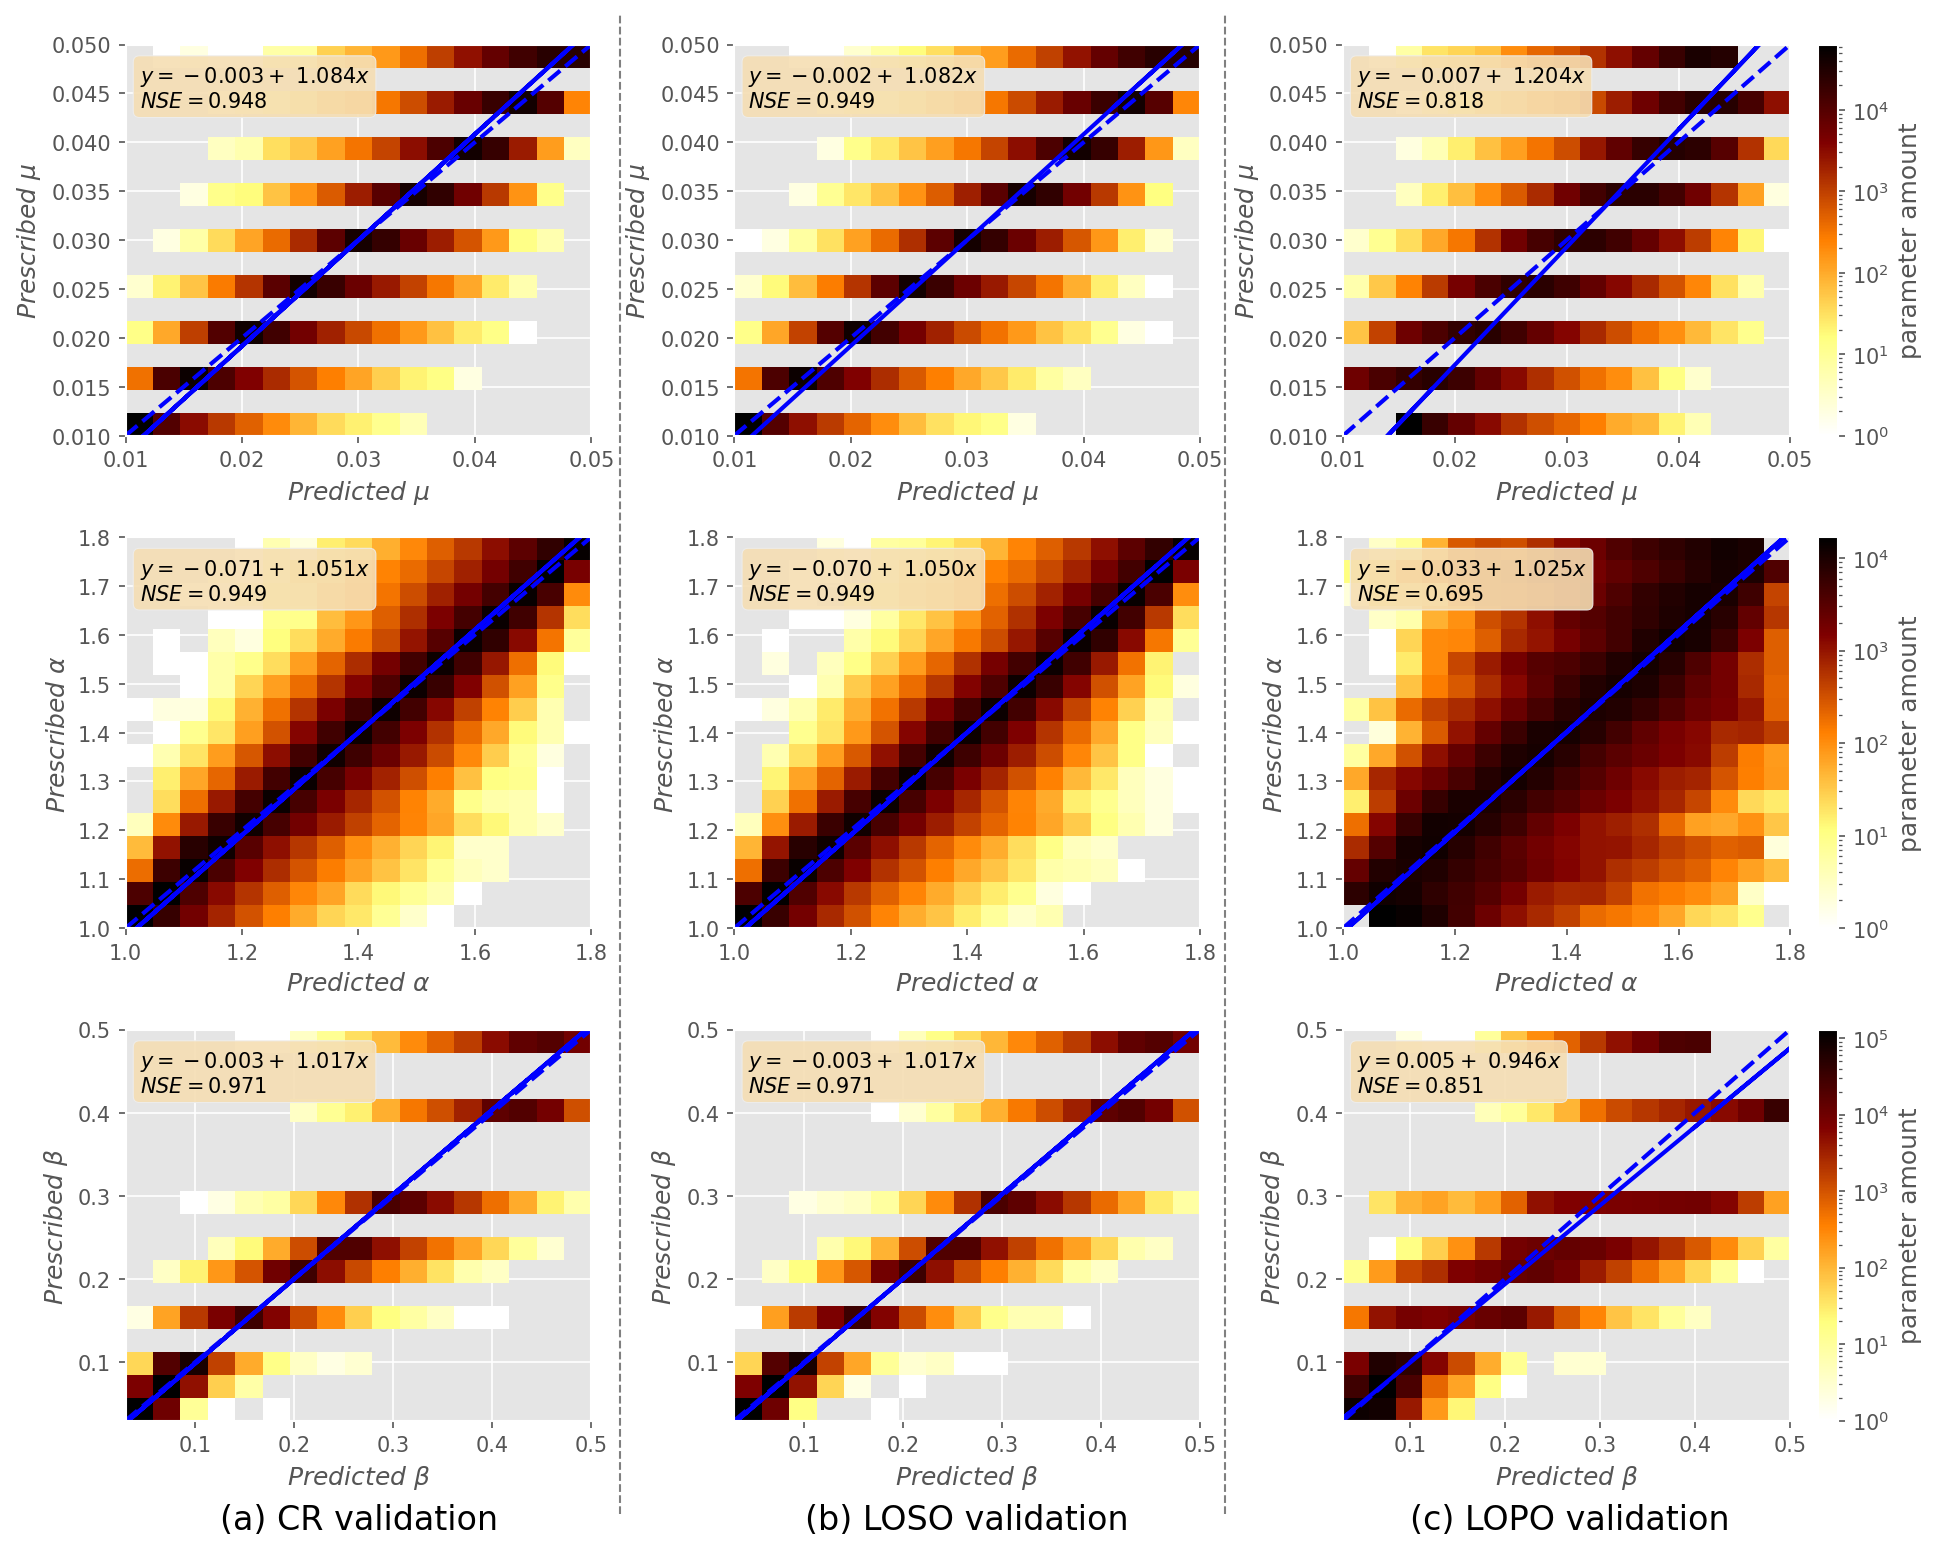

<Figure size 1950x1500 with 0 Axes>

In [6]:
# merge all scatter plots
plt.style.use('ggplot')
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = (13,10)

fig,axs = plt.subplots(3,3,gridspec_kw={'width_ratios': [1, 1, 1.2]})
plt.plot([0.315, 0.315], [0, 1], '--',color='gray', lw=1,transform=gcf().transFigure, clip_on=False)
plt.plot([0.625, 0.625], [0, 1], '--',color='gray', lw=1,transform=gcf().transFigure, clip_on=False)
plt.figtext(0.11,-0.01,'(a) CR validation',fontsize=16)
plt.figtext(0.41,-0.01,'(b) LOSO validation',fontsize=16)
plt.figtext(0.72,-0.01,'(c) LOPO validation',fontsize=16)
# 10 Fold
# col_names = ['mu','alpha','beta']
# i=0
# for col in col_names:
#     True_para = np.array(df_all[col]).flatten()
#     Pred_para = np.array(df_pre[col],dtype='float64').flatten()
#     #r2 = r2_score(True_para, Pred_para)
#     nse = he.evaluator(he.nse,Pred_para,True_para)
#     my_plot(Pred_para,True_para,nse,17,True,r'./newplot/Kb[0.025:0.2]/5fold/M_%s_10CV.png'%(col),col)
cv5_pred = cv5_pred.astype('float64')
cv5_true = cv5_true.astype('float64')
ax_plot(axs[0,0],cv5_pred['mu'],cv5_true['mu'],bin=17,drp='mu')
ax_plot(axs[1,0],cv5_pred['alpha'],cv5_true['alpha'],bin=17,drp='alpha')
ax_plot(axs[2,0],cv5_pred['beta'],cv5_true['beta'],bin=17,drp='beta')
# LOSO
LOSO_pred = LOSO_pred.astype('float64')
LOSO_true = LOSO_true.astype('float64')
ax_plot(axs[0,1],LOSO_pred['mu'],LOSO_true['mu'],bin=17,drp='mu')
ax_plot(axs[1,1],LOSO_pred['alpha'],LOSO_true['alpha'],bin=17,drp='alpha')
ax_plot(axs[2,1],LOSO_pred['beta'],LOSO_true['beta'],bin=17,drp='beta')
# LOPO
ax_plot(axs[0,2],LOPO_pred_mu,LOPO_true_mu,bin=17,drp='mu',colorbar=True)
ax_plot(axs[1,2],LOPO_pred_alpha,LOPO_true_alpha,bin=17,drp='alpha',colorbar=True)
ax_plot(axs[2,2],LOPO_pred_beta,LOPO_true_beta,bin=17,drp='beta',colorbar=True)
plt.subplots_adjust(wspace=0.35, hspace=0.3)
plt.tight_layout()
plt.show()
plt.savefig('./Figure6(a-c).png',bbox_inches = 'tight')


## test the extrapolation

In [ ]:
%store -r CV5_mu
%store -r CV5_a
%store -r CV5_beta
%store -r cv5_true
%store -r cv5_pred

%store -r LOSO_mu
%store -r LOSO_a
%store -r LOSO_beta
%store -r LOSO_true
%store -r LOSO_pred

%store -r LOPO_true_mu
%store -r LOPO_pred_mu
%store -r LOPO_true_beta
%store -r LOPO_pred_beta
%store -r LOPO_true_alpha
%store -r LOPO_pred_alpha

exclude the boundary predictions

In [ ]:
fig,axs = plt.subplots(1,3,figsize=(12,3),gridspec_kw={'width_ratios': [1, 1, 1.2]})
plt.style.use('ggplot')
plt.rcParams['figure.dpi'] = 150

min_mu = np.where(LOPO_true_mu==LOPO_true_mu.min())
max_mu = np.where(LOPO_true_mu==LOPO_true_mu.max())
LOPO_pred_mu_inner = np.delete(LOPO_pred_mu,[min_mu,max_mu])
LOPO_true_mu_inner = np.delete(LOPO_true_mu,[min_mu,max_mu])
ax_plot(axs[0],LOPO_pred_mu_inner,LOPO_true_mu_inner,bin=17,drp='mu')

min_alpha = np.where(LOPO_true_alpha==LOPO_true_alpha.min())
max_alpha = np.where(LOPO_true_alpha==LOPO_true_alpha.max())
LOPO_pred_alpha_inner = np.delete(LOPO_pred_alpha,[min_alpha,max_alpha])
LOPO_true_alpha_inner = np.delete(LOPO_true_alpha,[min_alpha,max_alpha])
ax_plot(axs[1],LOPO_pred_alpha_inner,LOPO_true_alpha_inner,bin=17,drp='alpha')

min_beta = np.where(LOPO_true_beta==LOPO_true_beta.min())
max_beta = np.where(LOPO_true_beta==LOPO_true_beta.max())
LOPO_pred_beta_inner = np.delete(LOPO_pred_beta,[min_beta,max_beta])
LOPO_true_beta_inner = np.delete(LOPO_true_beta,[min_beta,max_beta])
ax_plot(axs[2],LOPO_pred_beta_inner,LOPO_true_beta_inner,bin=17,drp='beta',colorbar=True)
plt.subplots_adjust(wspace=0.35, hspace=0.3)
plt.tight_layout()
# ax_plot(axs[1,0],LOSO_pred['alpha'],LOSO_true['alpha'],bin=17,drp='alpha')
# ax_plot(axs[2,0],LOSO_pred['beta'],LOSO_true['beta'],bin=17,drp='beta')

1. Redo the LOPO, but keep the boundary parameters into the training dataset to avoid extrapolation, and see the NSE change 

In [ ]:
def lopo_mu_extrapolation(mode='multi'):
    df_lopo= df_3.drop(['entropy','Shuffle_index'],axis=1)
    mus = Col_unique_values(df_lopo,'mu')

    Pred_mus = []
    True_mus = []
    for mu in mus:
        mu_value = mu
        # keep the boundary parameters into training dataset
        if mu_value != mus.max() and mu_value != mus.min():
            df_train = df_lopo[df_lopo['mu'] != mu_value]
        else:
            df_train = df_lopo
        df_train = df_train.reset_index(drop = True)
        df_test = df_lopo[df_lopo['mu'] == mu_value]
        df_test = df_test.reset_index(drop = True)
        
        if mode == 'multi':
            Pred_mu = single_multi(df_train,df_test,'mu')
        elif mode == 'chained':
            Pred_mu = single_chained(df_train,df_test,'mu')
        else:
            print("Wrong mode inputs!!")
        
        Pred_mus.append(np.array(Pred_mu))
        True_mus.append(np.zeros(np.size(Pred_mu))+mu)

    #labels = '0.01','0.015','0.02','0.025','0.03','0.035','0.04','0.45','0.05'
    labels = np.array(df_3['mu'].round(3).unique(), dtype=str)
    plt.figure(figsize=(7,5),dpi=150)
    plt.title('mus of boxplot',fontsize=20)
    plt.boxplot(Pred_mus, labels = labels,vert=False)
    # data.boxplot()
    plt.ylabel('Prescribed Mu')
    plt.xlabel('Predicted Mu')
    plt.show()

    True_mus = np.array(True_mus).flatten()
    Pred_mus = np.array(Pred_mus).flatten()
    r2 = r2_score(True_mus, Pred_mus)
    nse = he.evaluator(he.nse,Pred_mus,True_mus)
    flag = 'withgpp'
    my_plot(Pred_mus,True_mus,nse,17,True,r'./newplot/Kb[0.025:0.2]/LOPO/M_mu_LOPO_%s_extrapolation.png'%(flag),'mu')
    return True_mus, Pred_mus, nse
    
def lopo_alpha_extrapolation(mode='multi'):
    df_lopo= df_3.drop(['entropy','Shuffle_index'],axis=1)
    alphas = Col_unique_values(df_lopo,'alpha')
    Pred_alphas = []
    True_alphas = []
    for alpha in alphas:
        alpha_value = alpha
        # keep the boundary parameters into training dataset
        if alpha_value != alphas.max() and alpha_value != alphas.min():
            df_train = df_lopo[df_lopo['alpha'] != alpha_value]
        else:
            df_train = df_lopo
            
        df_train = df_train.reset_index(drop = True)
        df_test = df_lopo[df_lopo['alpha'] == alpha_value]
        df_test = df_test.reset_index(drop = True)
        
        if mode == 'multi':
            Pred_alpha = single_multi(df_train,df_test,'alpha')
        elif mode == 'chained':
            Pred_alpha = single_chained(df_train,df_test,'alpha')
        else:
            print("Wrong mode inputs!!")
        
        Pred_alphas.append(np.array(Pred_alpha))
        True_alphas.append(np.zeros(np.size(Pred_alpha))+alpha)
        print(alpha)
        
        
    labels = '1.0', '1.05', '1.1', '1.15', '1.2','1.25', '1.3', '1.35', '1.4', '1.45', '1.5','1.55', '1.6','1.65', '1.7', '1.75','1.8'
    plt.figure(figsize=(7,5),dpi = 150)
    plt.title('Alphas of boxplot',fontsize=20)
    plt.boxplot(Pred_alphas, labels = labels,vert=False)
    # data.boxplot()
    plt.ylabel('Prescribed Alpha')
    plt.xlabel('Predicted Alpha')
    plt.show()

    True_alphas = np.array(True_alphas).flatten()
    Pred_alphas = np.array(Pred_alphas).flatten()
    r2 = r2_score(True_alphas, Pred_alphas)
    nse = he.evaluator(he.nse,Pred_alphas,True_alphas)
    #my_plot(Pred_alphas,True_alphas,r2,nse)
    flag = 'withgpp'
    my_plot(Pred_alphas,True_alphas,nse,17,True,r'./newplot/Kb[0.025:0.2]/LOPO/M_alpha_LOPO_%s_extrapolation.png'%(flag),'alpha')
    return True_alphas, Pred_alphas, nse

def lopo_beta_extrapolation(mode='multi'):
    df_3['beta']= df_3['beta'].round(2)
    df_lopo= df_3.drop(['entropy','Shuffle_index'],axis=1)
    Iss = Col_unique_values(df_lopo,'beta')
    Pred_Iss = []
    True_Iss = []
    for Is in Iss:
        Is_value = Is
        if Is_value != Iss.max() and Is_value != Iss.min():
            df_train = df_lopo[df_lopo['beta'] != Is_value]
        else:
            df_train = df_lopo
        df_train = df_train.reset_index(drop = True)
        df_test = df_lopo[df_lopo['beta'] == Is_value]
        df_test = df_test.reset_index(drop = True)
        
        if mode == 'multi':
            Pred_Is = single_multi(df_train,df_test,'beta')
        elif mode == 'chained':
            Pred_Is = single_chained(df_train,df_test,'beta')
        else:
            print("Wrong mode inputs!!")
            
        Pred_Iss.append(np.array(Pred_Is))
        True_Iss.append(np.zeros(np.size(Pred_Is))+Is)
        print(Is)
    labels = '0.03', '0.04', '0.05', '0.06', '0.07', '0.08', '0.09', '0.1','0.15', '0.2','0.25', '0.3', '0.4', '0.5'

    plt.figure(figsize=(7,5),dpi=150)
    plt.title('Boxplot of Beta',fontsize=20)
    plt.boxplot(Pred_Iss, labels = labels,vert=False)
    # data.boxplot()
    plt.ylabel('Prescribed Beta')
    plt.xlabel('Predicted Beta')
    plt.show()

    True_Iss = np.array(True_Iss).flatten()
    Pred_Iss = np.array(Pred_Iss).flatten()
    r2 = r2_score(True_Iss, Pred_Iss)
    nse = he.evaluator(he.nse,Pred_Iss,True_Iss)
    #my_plot(Pred_Iss,True_Iss,r2,nse)
    flag = 'withgpp'
    my_plot(Pred_Iss,True_Iss,nse,17,True,r'./newplot/Kb[0.025:0.2]/LOPO/M_beta_LOPO_%s_extrapolation.png'%(flag),'beta')
    return True_Iss, Pred_Iss, nse

In [ ]:
True_mus_extrapolation, Pred_mus_extrapolation, nse = lopo_mu_extrapolation(mode='multi')
True_alphas_extrapolation, Pred_alphas_extrapolation, nse = lopo_alpha_extrapolation(mode='multi')
True_betas_extrapolation, Pred_betas_extrapolation, nse = lopo_beta_extrapolation(mode='multi')

In [ ]:
%store True_mus_extrapolation
%store Pred_mus_extrapolation
%store True_alphas_extrapolation
%store Pred_alphas_extrapolation
%store True_betas_extrapolation
%store Pred_betas_extrapolation

In [ ]:
fig,axs = plt.subplots(1,3,figsize=(12,3),gridspec_kw={'width_ratios': [1, 1, 1.2]})
plt.style.use('ggplot')
plt.rcParams['figure.dpi'] = 150

ax_plot(axs[0],Pred_mus_extrapolation,True_mus_extrapolation,bin=17,drp='mu')

ax_plot(axs[1],Pred_alphas_extrapolation,True_alphas_extrapolation,bin=17,drp='alpha')

ax_plot(axs[2],Pred_betas_extrapolation,True_betas_extrapolation,bin=17,drp='beta',colorbar=True)

plt.subplots_adjust(wspace=0.35, hspace=0.3)
plt.tight_layout()

2. Replace LOPO bondary predictions with LOSO predictions. Use a LOSO model to predict the boundary parameters.


In [ ]:
def LOSO_fit(df_train, flag = ''):
    
    j = df_train.shape[1]
    
    df = df_train
    df_x = df.iloc[:,3:j]
    df_y = df.iloc[:,0:3]

    x = df_x.values
    y = df_y.values

    # define model
    model = RandomForestRegressor(n_jobs = -1)
    model.fit(x, y)
    
    return model

df_all= df_3
df_all

for i in range(1,11):
    i=2
    df_test = df_all.loc[df_all['Shuffle_index'] == i]
    df_test= df_test.drop(['entropy','Shuffle_index'],axis=1)
    df_test = df_test.reset_index(drop = True)
    
    df_train = df_all.loc[df_all['Shuffle_index'] != i]
    df_train= df_train.drop(['entropy','Shuffle_index'],axis=1)
    df_train = df_train.reset_index(drop = True)   
    
    #print('Shuffle No.{}'.format(i+1),'\n','Multi-Output:')
    LOSO_model = LOSO_fit(df_train,flag = r'shuffle_%d'%(i+1))
    #df_pre.loc[df_all['Shuffle_index'] == i] = y_pre.values
    break



In [ ]:
%store LOSO_model

In [ ]:
def lopo_mu_extrapolation2(LOSO_model):
    df_lopo= df_3.drop(['entropy','Shuffle_index'],axis=1)
    mus = Col_unique_values(df_lopo,'mu')

    Pred_mus = []
    True_mus = []
    for mu in mus:
        mu_value = mu
        # keep the boundary parameters into training dataset
        if mu_value != mus.max() and mu_value != mus.min():
            df_train = df_lopo[df_lopo['mu'] != mu_value]
            df_train = df_train.reset_index(drop = True)
            df_test = df_lopo[df_lopo['mu'] == mu_value]
            df_test = df_test.reset_index(drop = True)
            Pred_mu = single_multi(df_train,df_test,'mu')
            
        else:
            df_test = df_lopo[df_lopo['mu'] == mu_value]
            df_test = df_test.reset_index(drop = True)
            
            df_vx = df_test.iloc[:,3:]
            df_vy = df_test.iloc[:,0:3]

            # make a prediction
            yhat = LOSO_model.predict(df_vx)
            y_pre = pd.DataFrame(yhat)
            Pred_mu = y_pre.iloc[:,0]
            #alpha y_pre.iloc[:,1] beta y_pre.iloc[:,2]

        Pred_mus.append(np.array(Pred_mu))
        True_mus.append(np.zeros(np.size(Pred_mu))+mu)

    #labels = '0.01','0.015','0.02','0.025','0.03','0.035','0.04','0.45','0.05'
    labels = np.array(df_3['mu'].round(3).unique(), dtype=str)
    plt.figure(figsize=(7,5),dpi=150)
    plt.title('mus of boxplot',fontsize=20)
    plt.boxplot(Pred_mus, labels = labels,vert=False)
    # data.boxplot()
    plt.ylabel('Prescribed Mu')
    plt.xlabel('Predicted Mu')
    plt.show()

    True_mus = np.array(True_mus).flatten()
    Pred_mus = np.array(Pred_mus).flatten()
    r2 = r2_score(True_mus, Pred_mus)
    nse = he.evaluator(he.nse,Pred_mus,True_mus)
    flag = 'withgpp'
    my_plot(Pred_mus,True_mus,nse,17,True,r'./newplot/Kb[0.025:0.2]/LOPO/M_mu_LOPO_%s_extrapolation2.png'%(flag),'mu')
    return True_mus, Pred_mus, nse
    
def lopo_alpha_extrapolation2(LOSO_model):
    df_lopo= df_3.drop(['entropy','Shuffle_index'],axis=1)
    alphas = Col_unique_values(df_lopo,'alpha')
    Pred_alphas = []
    True_alphas = []
    for alpha in alphas:
        alpha_value = alpha
        # keep the boundary parameters into training dataset
        if alpha_value != alphas.max() and alpha_value != alphas.min():
            df_train = df_lopo[df_lopo['alpha'] != alpha_value]
            df_train = df_train.reset_index(drop = True)
            df_test = df_lopo[df_lopo['alpha'] == alpha_value]
            df_test = df_test.reset_index(drop = True)
            Pred_alpha = single_multi(df_train,df_test,'alpha')
            
        else:
            df_test = df_lopo[df_lopo['alpha'] == alpha_value]
            df_test = df_test.reset_index(drop = True)
            df_vx = df_test.iloc[:,3:]
            df_vy = df_test.iloc[:,0:3]

            # make a prediction
            yhat = LOSO_model.predict(df_vx)
            y_pre = pd.DataFrame(yhat)
            Pred_alpha = y_pre.iloc[:,1]
            #alpha y_pre.iloc[:,1] beta y_pre.iloc[:,2]
        
        Pred_alphas.append(np.array(Pred_alpha))
        True_alphas.append(np.zeros(np.size(Pred_alpha))+alpha)
        print(alpha)
        
        
    labels = '1.0', '1.05', '1.1', '1.15', '1.2','1.25', '1.3', '1.35', '1.4', '1.45', '1.5','1.55', '1.6','1.65', '1.7', '1.75','1.8'
    plt.figure(figsize=(7,5),dpi = 150)
    plt.title('Alphas of boxplot',fontsize=20)
    plt.boxplot(Pred_alphas, labels = labels,vert=False)
    # data.boxplot()
    plt.ylabel('Prescribed Alpha')
    plt.xlabel('Predicted Alpha')
    plt.show()

    True_alphas = np.array(True_alphas).flatten()
    Pred_alphas = np.array(Pred_alphas).flatten()
    r2 = r2_score(True_alphas, Pred_alphas)
    nse = he.evaluator(he.nse,Pred_alphas,True_alphas)
    #my_plot(Pred_alphas,True_alphas,r2,nse)
    flag = 'withgpp'
    my_plot(Pred_alphas,True_alphas,nse,17,True,r'./newplot/Kb[0.025:0.2]/LOPO/M_alpha_LOPO_%s_extrapolation2.png'%(flag),'alpha')
    return True_alphas, Pred_alphas, nse

def lopo_beta_extrapolation2(LOSO_model):
    df_3['beta']= df_3['beta'].round(2)
    df_lopo= df_3.drop(['entropy','Shuffle_index'],axis=1)
    Iss = Col_unique_values(df_lopo,'beta')
    Pred_Iss = []
    True_Iss = []
    for Is in Iss:
        Is_value = Is
        if Is_value != Iss.max() and Is_value != Iss.min():
            df_train = df_lopo[df_lopo['beta'] != Is_value]
            df_train = df_train.reset_index(drop = True)
            df_test = df_lopo[df_lopo['beta'] == Is_value]
            df_test = df_test.reset_index(drop = True)
            Pred_Is = single_multi(df_train,df_test,'beta')
        else:
            df_test = df_lopo[df_lopo['beta'] == Is_value]
            df_test = df_test.reset_index(drop = True)
            
            df_vx = df_test.iloc[:,3:]
            df_vy = df_test.iloc[:,0:3]

            # make a prediction
            yhat = LOSO_model.predict(df_vx)
            y_pre = pd.DataFrame(yhat)
            Pred_Is = y_pre.iloc[:,2]
            #Is y_pre.iloc[:,1] beta y_pre.iloc[:,2]
            
        Pred_Iss.append(np.array(Pred_Is))
        True_Iss.append(np.zeros(np.size(Pred_Is))+Is)
        print(Is)
    labels = '0.03', '0.04', '0.05', '0.06', '0.07', '0.08', '0.09', '0.1','0.15', '0.2','0.25', '0.3', '0.4', '0.5'

    plt.figure(figsize=(7,5),dpi=150)
    plt.title('Boxplot of Beta',fontsize=20)
    plt.boxplot(Pred_Iss, labels = labels,vert=False)
    # data.boxplot()
    plt.ylabel('Prescribed Beta')
    plt.xlabel('Predicted Beta')
    plt.show()

    True_Iss = np.array(True_Iss).flatten()
    Pred_Iss = np.array(Pred_Iss).flatten()
    r2 = r2_score(True_Iss, Pred_Iss)
    nse = he.evaluator(he.nse,Pred_Iss,True_Iss)
    #my_plot(Pred_Iss,True_Iss,r2,nse)
    flag = 'withgpp'
    my_plot(Pred_Iss,True_Iss,nse,17,True,r'./newplot/Kb[0.025:0.2]/LOPO/M_beta_LOPO_%s_extrapolation2.png'%(flag),'beta')
    return True_Iss, Pred_Iss, nse

def Col_unique_values(df,col_name):
    # Col_unique_values(df_train,'alpha')
    return df[col_name].value_counts().index.sort_values()

In [ ]:
True_mus_extrapolation2, Pred_mus_extrapolation2, nse = lopo_mu_extrapolation2(LOSO_model)



In [ ]:
%store True_mus_extrapolation2
%store Pred_mus_extrapolation2

In [ ]:
True_alphas_extrapolation2, Pred_alphas_extrapolation2, nse = lopo_alpha_extrapolation2(LOSO_model)

In [ ]:
%store True_alphas_extrapolation2
%store Pred_alphas_extrapolation2


In [ ]:
True_betas_extrapolation2, Pred_betas_extrapolation2, nse = lopo_beta_extrapolation2(LOSO_model)

In [ ]:
%store True_betas_extrapolation2
%store Pred_betas_extrapolation2

In [ ]:
fig,axs = plt.subplots(1,3,figsize=(12,3),gridspec_kw={'width_ratios': [1, 1, 1.2]})
plt.style.use('ggplot')
plt.rcParams['figure.dpi'] = 150

ax_plot(axs[0],Pred_mus_extrapolation2,True_mus_extrapolation2,bin=17,drp='mu')

ax_plot(axs[1],Pred_alphas_extrapolation2,True_alphas_extrapolation2,bin=17,drp='alpha')

ax_plot(axs[2],Pred_betas_extrapolation2,True_betas_extrapolation2,bin=17,drp='beta',colorbar=True)

plt.subplots_adjust(wspace=0.35, hspace=0.3)
plt.tight_layout()

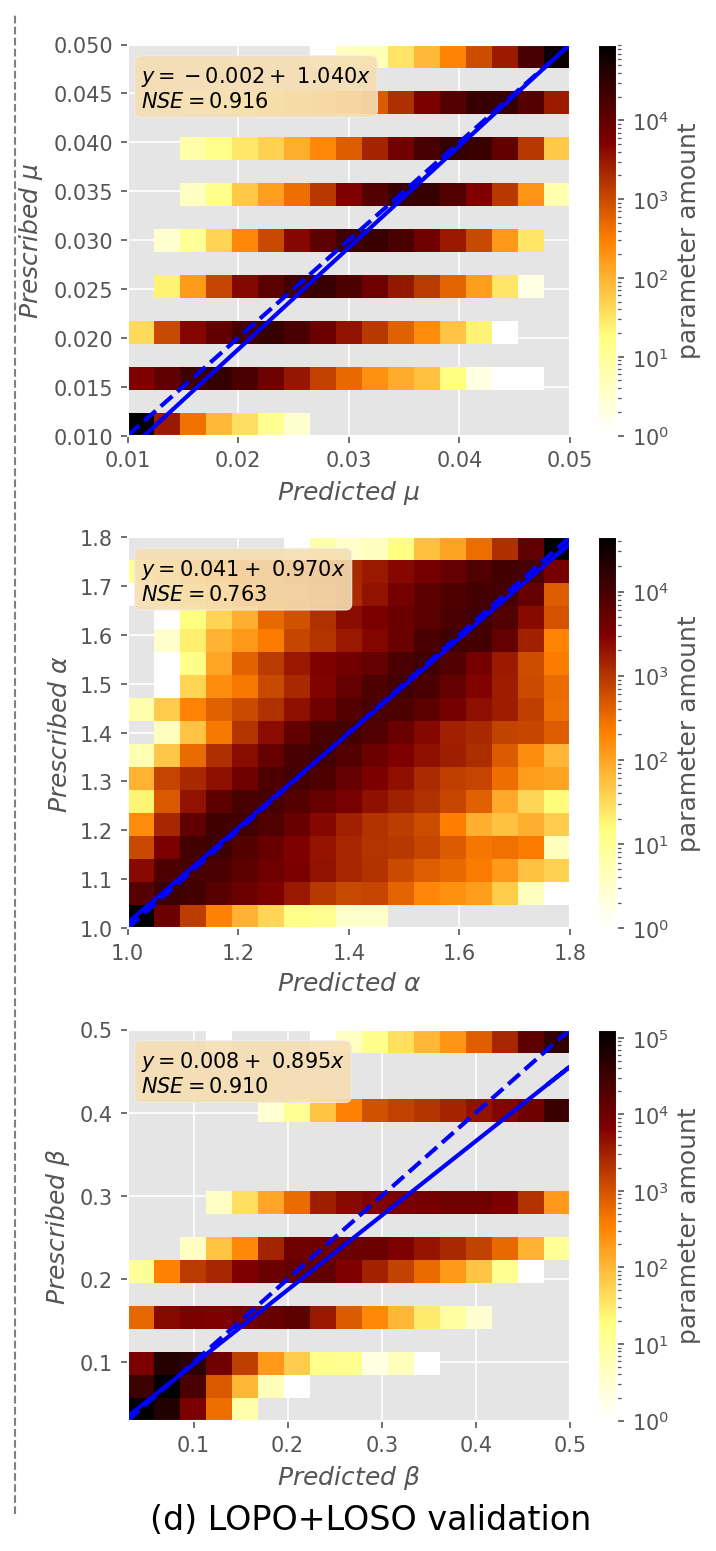

<Figure size 712.5x1500 with 0 Axes>

In [14]:
plt.style.use('ggplot')
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = (4.75,10)

fig,axs = plt.subplots(3,1)
plt.plot([0.01, 0.01], [0, 1], '--',color='gray', lw=1,transform=gcf().transFigure, clip_on=False)
plt.figtext(0.2,-0.01,'(d) LOPO+LOSO validation',fontsize=16)

ax_plot(axs[0],Pred_mus_extrapolation2,True_mus_extrapolation2,bin=17,drp='mu',colorbar=True)
ax_plot(axs[1],Pred_alphas_extrapolation2,True_alphas_extrapolation2,bin=17,drp='alpha',colorbar=True)
ax_plot(axs[2],Pred_betas_extrapolation2,True_betas_extrapolation2,bin=17,drp='beta',colorbar=True)
plt.subplots_adjust(wspace=0.35, hspace=0.3)
plt.tight_layout()
plt.show()
plt.savefig('./Figure6d.png')

